# Homework 5 (100 points) CNNs, AEs, GANs

## Task 1 (70 points): CNNs

### Part 1 (20 points): Custom CNN
This step involves downloading, preparing, and visualizing your
dataset. Create a convolutional base using a common pattern: a stack of Conv and
MaxPooling layers. Depending on the problem and the dataset you must decide what
pattern you want to use (i.e., how many Conv layers and how many pooling layers).
Please describe why you chose a particular pattern. Add the final dense layer(s).
Compile and train the model. Report the final evaluation and describe the metrics

#### Dataset & Preparation

For this task I have selected the PlantVillage, plant leaf diseases dataset available [here](https://data.mendeley.com/datasets/tywbtsjrjv/1) and [here](https://paperswithcode.com/dataset/plantvillage). The dataset contains images of different types of plants with and without various diseases. I have simplified the dataset to only look at the apples and their diseases. This greatly reduces the number of training examples and helps me run my models faster.  

In [1]:
import os

import torch
import torch.utils.data
import torchvision.io
import torchvision.transforms

class PlantVillageDataset(torch.utils.data.Dataset):
    def __init__(self):
        base_path = "data/PlantVillageDataset"
        self.images = [] #list of all image classes with their paths in a tuple (class_ohe, image path)
        self.image_classes = os.listdir(base_path)
        self.resize = torchvision.transforms.Resize((64, 64))
        for i, image_class in enumerate(self.image_classes):
            #image_class_ohe = torch.tensor([1 if j == i else 0 for j in range(len(self.image_classes))]) #one hot encoding for the class label
            image_names = os.listdir(f"{base_path}/{image_class}")
            for image_name in image_names:
                image_tensor = self.resize(torchvision.io.read_image(f"{base_path}/{image_class}/{image_name}"))/255
                self.images.append((image_tensor, i))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index]

dataset = PlantVillageDataset()

torch.Size([3, 64, 64])
0


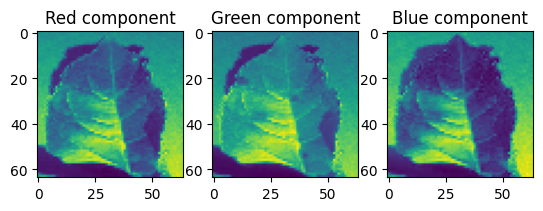

In [2]:
import matplotlib.pyplot as plt

print(dataset[10][0].shape)
print(dataset[10][1])

fig, ax = plt.subplots(ncols=3)
ax[0].set_title("Red component")
ax[0].imshow(dataset[10][0][0])
ax[1].set_title("Green component")
ax[1].imshow(dataset[10][0][1])
ax[2].set_title("Blue component")
ax[2].imshow(dataset[10][0][2])

We see that each image is composed of 3 color planes with a width and height of 64. We observe 4 classes in total. next we inspect the class distribution of the dataset. Due to the relatively even distribution of the classes we will use classification accuracy as our metric.

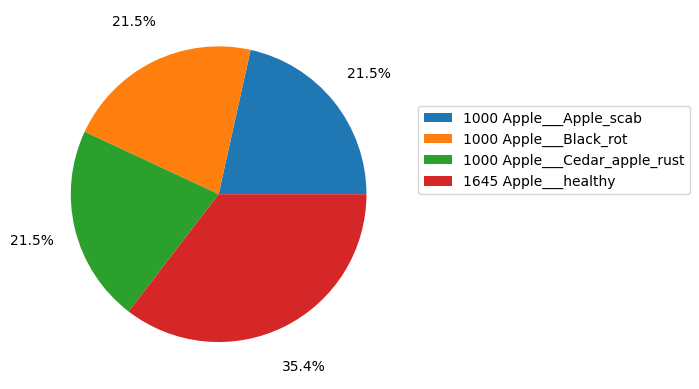

In [3]:
import numpy as np

def class_pie(dataset):
    class_indexes = [x[1] for x in dataset.images]
    class_counts = np.unique(class_indexes, return_counts=True)
    plt.pie(x=class_counts[1], autopct='%1.1f%%', pctdistance=1.3);
    plt.legend(labels=[str(class_counts[1][i]) + " " + dataset.image_classes[i] for i in range(len(class_counts[1]))], loc=(1.04, 0.5))

class_pie(dataset)

In [4]:
train_percent = 0.9
train_count = int(train_percent*len(dataset))
split_lengths = [train_count, len(dataset) - train_count]

train_dataset, test_dataset = torch.utils.data.random_split(dataset, split_lengths)

#### Custom CNN

We begin by writing some helper methods that we will use for many of the subsequent tasks.

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix

def as_tensors(dataset):
    return next(iter(torch.utils.data.DataLoader(dataset, batch_size=len(dataset))))

#predict the binary classes from X when fed through the model
def predict(model, X):
    model_outputs = model(X)
    predicted_classes = torch.argmax(model_outputs, dim=1)
    return predicted_classes

def print_accuracy_dataset(name, model, X, y):
    y_prime = predict(model, X)
    f1 = accuracy_score(y.detach().numpy(), y_prime.detach().numpy())
    print("Accuracy Score for {}: {:0.2f}%".format(name, f1*100))

In [6]:
import torch.nn
import torch.optim
import torch.utils.data

#hyperparameters
epochs = 15
batch_size = 128
optimizer = torch.optim.Adam
lossFunction = torch.nn.CrossEntropyLoss()

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [41]:
from ipywidgets import IntProgress
from IPython.display import display
import seaborn as sns

losses = None

def evaluate_cnn_model(model):
    print_accuracy_dataset("Training", model, *as_tensors(train_dataset))
    print_accuracy_dataset("Testing", model, *as_tensors(test_dataset))
    fig, ax = plt.subplots(nrows=2, figsize=(5,10)) 
    ax[0].set_title("Loss vs Time")
    ax[0].set_xlabel("Loss")
    ax[0].set_ylabel("Time")
    ax[0].plot(losses)
    x_test, y_test = as_tensors(train_dataset)
    test_confusion_matrix = confusion_matrix(y_test, predict(model, x_test).detach().numpy())
    ax[1].set_title("Testing Confusion Matrix")
    sns.heatmap(test_confusion_matrix, ax=ax[1], annot=True, cmap='RdYlGn', fmt='d')

def train_cnn_model(model):
    global losses 
    losses = []
    progress_bar = IntProgress(min=0, max=epochs*(len(dataset)//batch_size)) # instantiate the bar
    display(progress_bar) # display the bar
    model_optimizer = optimizer(model.parameters())
    print("Epochs: ")
    for epoch in range(epochs):
        print(str(epoch) + ",", end="")
        for X, y in train_dataloader:
            model_outputs = model(X)
            batch_cost = lossFunction(model_outputs, y)
            losses.append(batch_cost)
            model_optimizer.zero_grad()
            batch_cost.backward()
            model_optimizer.step()
            progress_bar.value += 1
    print("\b\n")

For my model I select a basic convilutional scheme that uses a Conv2d layer, with 3 input features, a 5x5 kernel, and stride of 1 followed by a MaxPool layer with a kernel and stride of 2. Due to the simple nature of the dataset I start with 10 output features for this layer rather than going for something big. The 3 input features correspond to the RGB planes of the image. The Max pool 2d layer effectively reduces the dimensionality by half. For the next section I repeat with another convilutional layer with 20 output features followed max pool before flattening. The flattening gets the convilutional layer this time is much smaller so we have more potential high level features for the dense layers. For my dense layers I used two linear layers with no activation on the output so that I could use CrossEntropyLoss effectively as this is a binary classification task. The reason I selected this architecture was because it is similar to the LeNet architecture which despite being old, is now a very shallow network that works well for simple tasks like this an MNIST. One of the main reasons I selected this layout was that it didn't take too long to run on my machine.

In [42]:
conv_model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 10, 5),  
    torch.nn.ReLU(), 
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(10, 20, 5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(4, 4),
    torch.nn.Flatten()
)

fully_connected_model = torch.nn.Sequential(
    torch.nn.Linear(720, 300),
    torch.nn.ReLU(),
    torch.nn.Linear(300, len(dataset.image_classes))
)

model = torch.nn.Sequential(conv_model, fully_connected_model)

train_cnn_model(model)

IntProgress(value=0, max=540)

Epochs: 
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14



Accuracy Score for Training: 92.30%
Accuracy Score for Testing: 88.82%


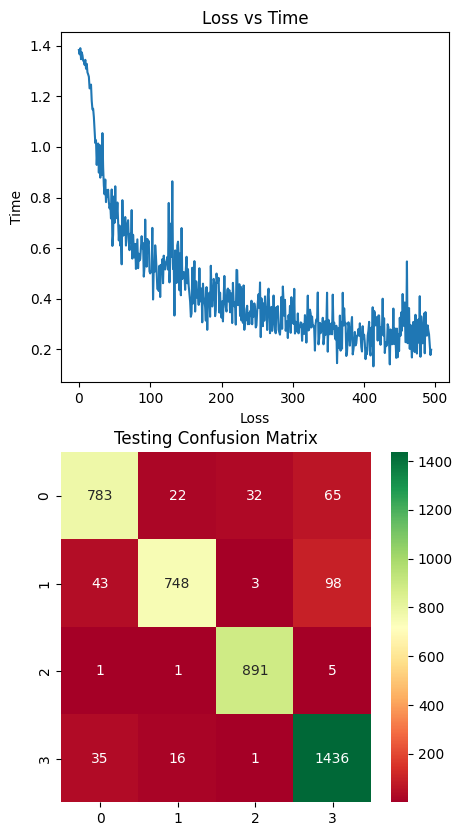

In [43]:
evaluate_cnn_model(model)

I chose to use accuracy to evaluate my model for two reasons. The first is that there are similar class breakdowns for the 3 classes, the second is that false positives don't affect us greatly, but compose the bulk of our miss-classifications (many more than false negatives) which have greater implications for this task. The model preforms quite well with ~95% accuracy on the training set and ~90% on the testing set. We observe good convergence in the loss vs time graph. In the confusion matrix we see that we have many more false positives then negatives. This is desireable as in real life false positives on this task would just involve spraying the apple tree with medicine it didn't need. 

### Part 2 (25 points): Using popular models
The following models are widely used for transfer learning because of
their performance and architectural innovations:
1. VGG (e.g., VGG16 or VGG19).
2. GoogLeNet (e.g., InceptionV3).
3. Residual Network (e.g., ResNet50).
4. MobileNet (e.g., MobileNetV2)
Choose any one of the above models to perform the classification task you did in Part 1.
Evaluate the results using the same metrics as in Part 1. Are there any differences? Why
or why not?

#### Learning With VGG11

I choose to use and evaluate the VGG11 model for this task, unfortunately when I tried with the pre-trained version of it it, my computer ran out of memory and crashed, hence I recreate it here.

In [7]:
import torchvision.models

vgg11 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 64, 3),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(64, 128, 3),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(128, 256, 3),
    torch.nn.ReLU(),
    torch.nn.Conv2d(256, 256, 3),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(256, 512, 3),
    torch.nn.ReLU(),
    torch.nn.Conv2d(512, 512, 3),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.5),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout2d(0.5),
    torch.nn.Linear(512, len(dataset.image_classes))
)

In [28]:

train_cnn_model(vgg11)

IntProgress(value=0, max=540)

Epochs: 
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14



Issues with this part crashing made me have to save and reload so I didn't need to wait for training every time

In [38]:
torch.save(vgg11.state_dict(), "VGG11.pt")
np.savez("losses.npz", np.array(losses))

In [16]:
vgg11.load_state_dict(torch.load("VGG11.pt"))
losses = np.load("losses.npz", allow_pickle=True)["arr_0"]

Redoing evaluation in a way that doesn't crash, full dataset batch size is apparently an issue with this network

In [17]:
def evaluate_accuracy(dataset, model):
    accSum = 0
    accCount = 0

    for X,y in torch.utils.data.DataLoader(dataset, batch_size=128):
        model_out = predict(model, X)
        accSum += accuracy_score(model_out, y)
        accCount += 1
    return accSum/accCount

Accuracy Score for train: 95.03%

Accuracy Score for test: 92.48%


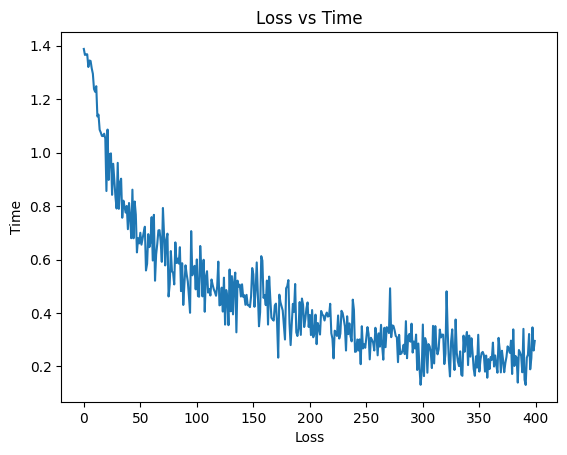

In [25]:
print("Accuracy Score for train: {:0.2f}%".format(evaluate_accuracy(train_dataset, vgg11)*100))
print()
print("Accuracy Score for test: {:0.2f}%".format(evaluate_accuracy(test_dataset, vgg11)*100))
plt.title("Loss vs Time")
plt.xlabel("Loss")
plt.ylabel("Time")
plt.plot(losses[:400])


In conclusion the VGG11 model preforms about as well as the original but works slightly better on the test data by about 2% on average. I hypothesize this is due to the larger size of the model, however it uses convolutions of size 3 which may be responsible for reducing the effectiveness.

### Part 3 (25 points): Data Augmentation
Use data augmentation to increase the diversity of your dataset by
Applying random transformations such as image rotation (you can use any other
technique as well). Repeat the process from part 1 with this augmented data. Did you
observe any difference in results?

#### Augmentation 

I repeat training my model from part 1 but this time by splicing in random rotations and random flips on batches

In [47]:
import torchvision.transforms

transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomVerticalFlip(0.2),
    torchvision.transforms.RandomHorizontalFlip(0.2),
    torchvision.transforms.RandomRotation((0, 360))
])

def train_cnn_model_with_Augmentation(model):
    global losses
    losses = []
    progress_bar = IntProgress(min=0, max=epochs*(len(dataset)//batch_size)) # instantiate the bar
    display(progress_bar) # display the bar
    model_optimizer = optimizer(model.parameters())
    print("Epochs: ")
    for epoch in range(epochs):
        print(str(epoch) + ",", end="")
        for X, y in train_dataloader:

            #apply the transformation to the batch for augmentation
            transformedX = transform(X)

            model_outputs = model(transformedX)
            batch_cost = lossFunction(model_outputs, y)
            losses.append(batch_cost)
            model_optimizer.zero_grad()
            batch_cost.backward()
            model_optimizer.step()
            progress_bar.value += 1
    print("\b\n")

We evaluate the same model from part 1

IntProgress(value=0, max=540)

Epochs: 
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14

Accuracy Score for Training: 87.54%
Accuracy Score for Testing: 85.81%


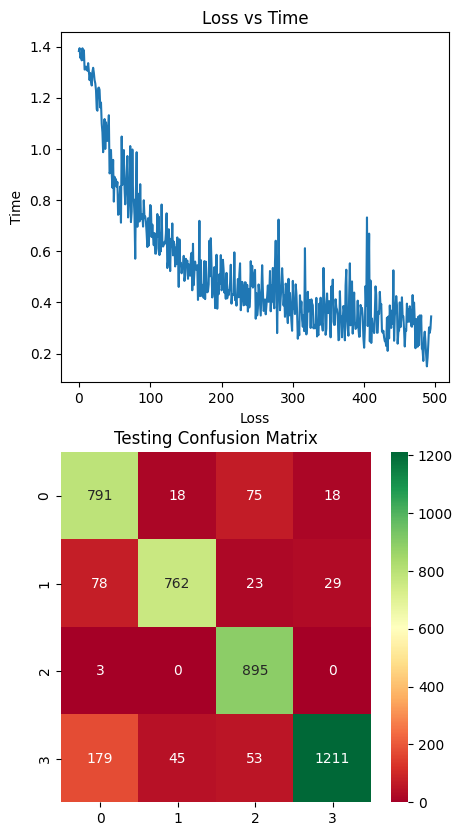

In [48]:
model3 = torch.nn.Sequential(
    torch.nn.Conv2d(3, 10, 5),  
    torch.nn.ReLU(), 
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(10, 20, 5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(4, 4),
    torch.nn.Flatten(),
    torch.nn.Linear(720, 300),
    torch.nn.ReLU(),
    torch.nn.Linear(300, len(dataset.image_classes))
)

train_cnn_model_with_Augmentation(model3)
evaluate_cnn_model(model3)

Overall the model preformed about 5% worse with the random rotations and flips. I hypothesize this is due to random image rotations it makes it harder to learn the diseases. We see there are lots more false negatives than before, particularly with it misidentifying things as healthy. One the bright side, there is more parity between the train and test sets meaning that this technique of dataset augmentation does indeed preform its desired goal of reducing overfitting. 

## Task 2 (30 Points): VAEs and GANs

### Part 1 (15 points): Variational Autoencoder (VAE):

Here is a complete implementation
of a VAE in TensorFlow: https://www.tensorflow.org/tutorials/generative/cvae
Following these steps try generating images using the same encoder-decoder architecture using
a different Image dataset (other than MNIST).

#### Implementation

We use the fashion-MNIST dataset as our generation target, obviously this is much harder to work on then digits because there is a lot more complexity to clothing and nuance between different parts of the clothes. We begin by loading the dataset and processing it similarly to torch's Dataset. We ignore labels as we don't care about them since this is an unsupervised learning task. 

In [20]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

#Load the fashion-MNIST dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_size = 6000
batch_size = 32
test_size = 1000

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [21]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()

        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim)
        ])
        self.decoder = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),
        ])

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss #I manually return the loss here

def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('vaefigs/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Epoch: 10, Test set ELBO: -192.2769012451172, time elapse for current epoch: 30.3072988986969


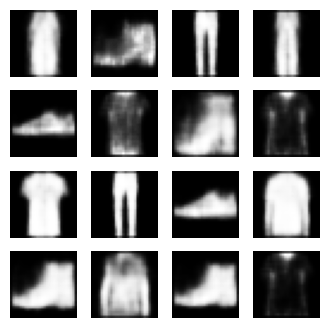

In [22]:

# Hyperparameters

epochs = 10
latent_dim = 2  # this number of latent dimensions, 2 is good cause we need to visualize it in 2d space
num_examples_to_generate = 16

# Pick a sample of the test set for generating output images
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]
generate_and_save_images(model, 0, test_sample)

losses = []
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        xloss = train_step(model, train_x, optimizer)
        losses.append(xloss)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)

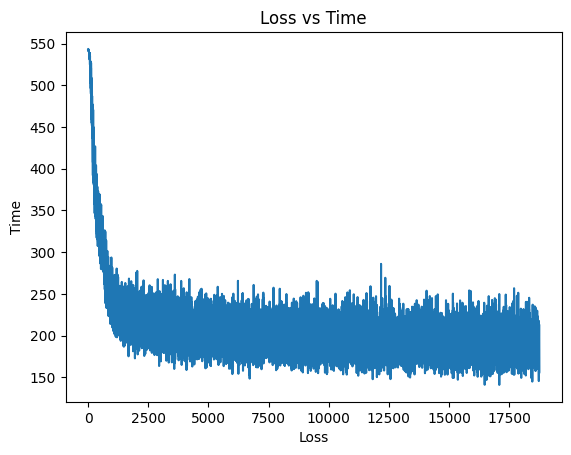

In [23]:
plt.title("Loss vs Time")
plt.xlabel("Loss")
plt.ylabel("Time")
plt.plot(losses)

We see that the model converges to a point, but even our final generated images are still pretty blurry and just make out the shapes of shoes shirts and pants. We now investigate the ranom points in the latent space over time by generating a gif and take a look into the latent space.


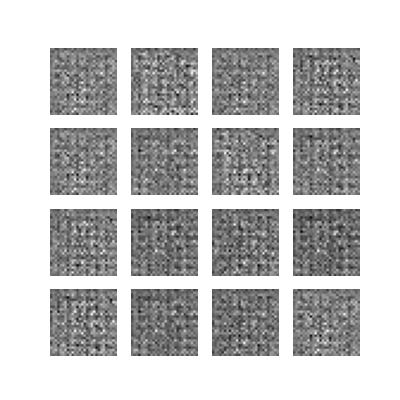

In [27]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('vaefigs/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

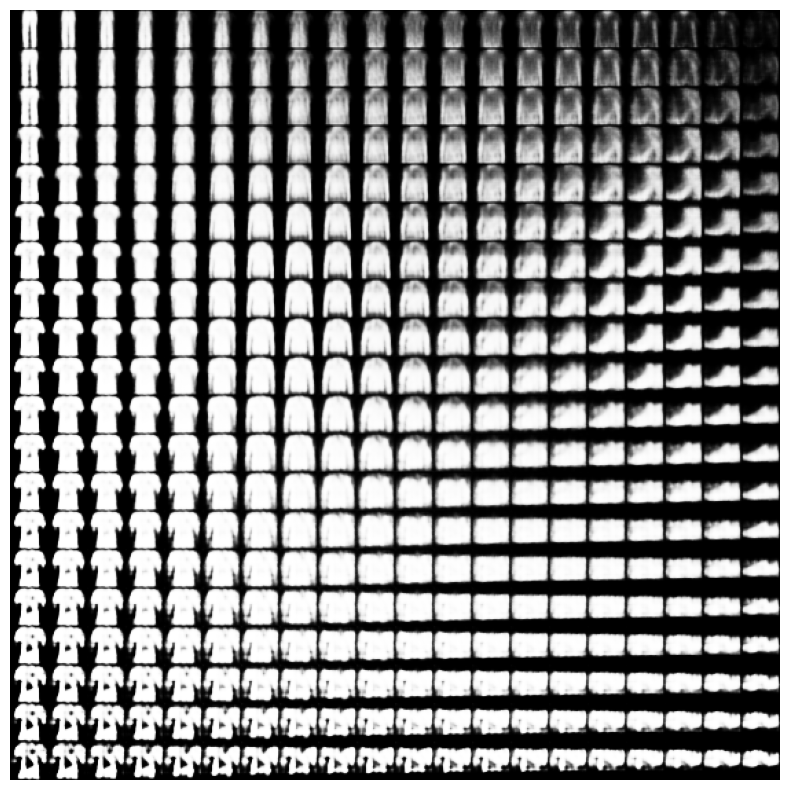

In [29]:
def plot_latent_images(model, n, digit_size=28):
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

plot_latent_images(model, 20)

We see in our gif over time that the model really does not progress all that much. The latent image view of the latent space reveals an interesting distribution of the various clothing articles.

### Part 2 (15 points): Generative Adversarial Networks (GANs):

Repeat part 1 (use same dataset) and implement a GAN model to generate high quality synthetic images. You may
follow steps outlined here: https://www.tensorflow.org/tutorials/generative/dcgan

#### Implementation

In [39]:
from tensorflow.keras import layers

#load data
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
BUFFER_SIZE = 6000
BATCH_SIZE = 256

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('ganfigs/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

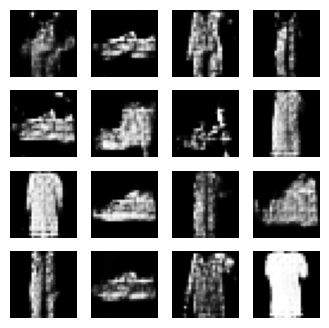

In [40]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

generator = make_generator_model()
discriminator = make_discriminator_model()

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

gen_losses = []
disc_losses = []

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

train(train_dataset, EPOCHS)

In [41]:
generator.save("generator.h5")
discriminator.save("discriminator.h5")


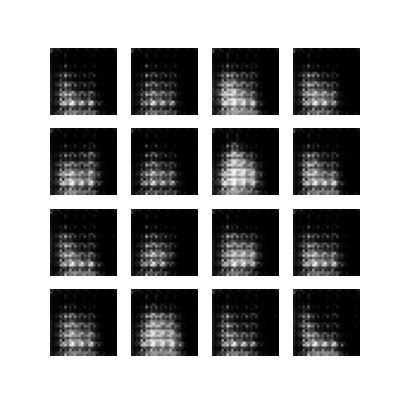

In [43]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('ganfigs/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

embed.embed_file(anim_file)

In conclusion, it appears that is true that the GAN in the long run performs much better than the VAE for generating high quality synthetic images, however for the same amount of data the GAN took almost 2 hours while the VAE only took 6 minutes. 

## Final Project Progress Report

So far my work has primarily consisted of research and preparation for the task at hand. My project is intended to augment RL policies in environments with significant logical constraints on actions. For example in an environment where the agent has in its action space the ability to walk into a wall, but the environment has a logical constraint that the agent is strictly forbidden from preforming the action of walking into the wall, the best solution is to select the highest ranked logically consistent legal action that the policy outputs. However, this isn't ideal in situations with large numbers of logical constraints on actions as we also want the policy to learn that these actions are illegal and not rank them very highly, hence this work seeks to augment the policy training with a means of cutting down recommendations of illegal actions. One paper I am currently reading on this problem is [A Closer Look at Invalid Action Masking in Policy Gradient Algorithms](https://arxiv.org/pdf/2006.14171.pdf). This paper is more so interested in the potential of boosting performance on RL tasks in environments with logical constraints by "masking" these illegal actions effectively, in their research they find that masking these logically illegal actions scales well, giving performance on the same level as giving high cost for invalid actions. Other than this I have begun implementing my RL models using a DQN.